In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.stats as stats

##### Load the data
The parameters are stored in the data folder. We load the best model's parameter for each subject. This model is an HDDM with 7 parameters. 
1. z: Starting point
2. t: Non-decision time
3. a: Boundary separation
4. v_intercept: Fixed utility bias
5. v_gain: Utility weight for gain
6. v_loss: Utility weight for loss
7. theta: linear rate of boundary shrinkage

In [21]:
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")[["param_name", "mean", "sub", "condition"]]
# We will include lambda as a parameter, which is the ratio of the drift rate towards gain to the drift rate towards loss
lmbda = {}
lmbda["param_name"] = "lambda"
lmbda["mean"] = np.abs(all_params_fit.query("param_name == 'v_loss'")["mean"].values / all_params_fit.query("param_name == 'v_gain'")["mean"].values)
lmbda["sub"] = all_params_fit.query("param_name == 'v_loss'")["sub"].values
lmbda["condition"] = all_params_fit.query("param_name == 'v_loss'")["condition"].values
lmbda = pd.DataFrame(lmbda)
all_params_fit = pd.concat([all_params_fit, lmbda])

### Difference of parameters between conditions

Independent t-tests are used to determine if the parameters are statistically different between conditions.

In [24]:
for param in all_params_fit["param_name"].unique():
    print(param)
    print(stats.ttest_ind(all_params_fit.query(f"param_name == '{param}' & condition == 'equalRange'")["mean"], all_params_fit.query(f"param_name == '{param}' & condition == 'equalIndifference'")["mean"]))

a
TtestResult(statistic=np.float64(-1.968543142075848), pvalue=np.float64(0.05434677456947008), df=np.float64(52.0))
z
TtestResult(statistic=np.float64(-1.3367628802222287), pvalue=np.float64(0.18711936369284943), df=np.float64(52.0))
t
TtestResult(statistic=np.float64(0.05427943879583733), pvalue=np.float64(0.9569205377446834), df=np.float64(52.0))
theta
TtestResult(statistic=np.float64(-0.11547498375661319), pvalue=np.float64(0.9085134248824187), df=np.float64(52.0))
v_Intercept
TtestResult(statistic=np.float64(-0.7672288348771935), pvalue=np.float64(0.44641515151259126), df=np.float64(52.0))
v_gain
TtestResult(statistic=np.float64(10.461154028971155), pvalue=np.float64(2.141023769507238e-14), df=np.float64(52.0))
v_loss
TtestResult(statistic=np.float64(-2.8544189712255763), pvalue=np.float64(0.00617827921855072), df=np.float64(52.0))
lambda
TtestResult(statistic=np.float64(-4.372535224001907), pvalue=np.float64(5.913687896279127e-05), df=np.float64(52.0))


**Findings:**
- Not statistically different:
    - Boundary separation (a)
    - Non-decision time (t)
    - Starting point (z)
    - v_intercept
- Statistically different:
    - v_gain (equalRange > equalIndifference)
    - v_loss (equalRange > equalIndifference in absolute value)
    - lambda (equalIndifference > equalRange)

As subjects sample gambles in high reward condition, they require more time (or information) to decide on rejecting a potential loss as compared to the gain as compared to the low reward condition. This suggests that, in this experiment, the response bias does not drive the effect of the behavior. Instead, the effect of the behavior is driven by how the subjects accumulate information about the prospects of the gambles. 

Hence, in our experiment, the utility weight on the gain/loss adapts to the condition. 

#### Plotting the parameters

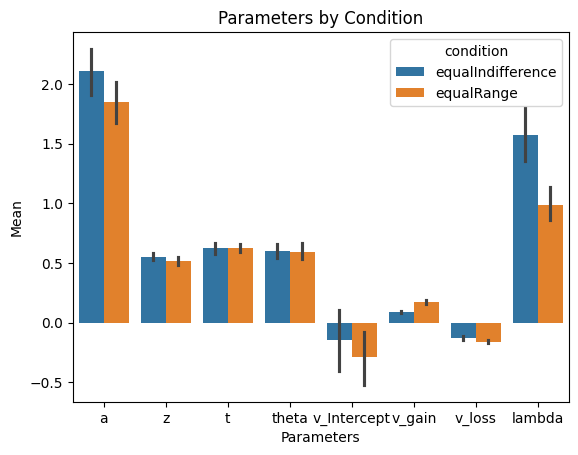

In [25]:
sns.barplot(data=all_params_fit, x="param_name", y="mean", hue="condition")
# x-axis is Parameters, y-axis is Mean, hue is condition
plt.xlabel("Parameters")
plt.ylabel("Mean")
plt.title("Parameters by Condition")
plt.show()

#### Load the behavioral data
Extract the probability of accepting the gamble for each subject and correlate with the parameters. 

In [36]:
behav_data = pd.read_csv('../../data/behavioral_data.csv')
accept_rate = behav_data.groupby(["sub", "condition"])["accept"].mean().reset_index()
accept_rate = accept_rate.merge(all_params_fit, on=["sub", "condition"])

In [38]:
for param in all_params_fit["param_name"].unique():
    print(param)
    print(stats.pearsonr(accept_rate.query(f"param_name == '{param}'")["accept"], accept_rate.query(f"param_name == '{param}'")["mean"]))

a
PearsonRResult(statistic=np.float64(0.2778069275411256), pvalue=np.float64(0.041960061939488986))
z
PearsonRResult(statistic=np.float64(0.6712845507850874), pvalue=np.float64(2.768561461015642e-08))
t
PearsonRResult(statistic=np.float64(-0.13476357588925858), pvalue=np.float64(0.33126182894765654))
theta
PearsonRResult(statistic=np.float64(0.06933231478865057), pvalue=np.float64(0.6183676365749324))
v_Intercept
PearsonRResult(statistic=np.float64(0.20071479567987188), pvalue=np.float64(0.1455888053369973))
v_gain
PearsonRResult(statistic=np.float64(-0.37118291317764207), pvalue=np.float64(0.005722451133168512))
v_loss
PearsonRResult(statistic=np.float64(0.5120635954657077), pvalue=np.float64(7.559164687213907e-05))
lambda
PearsonRResult(statistic=np.float64(0.025780700470435992), pvalue=np.float64(0.8531925690229633))


**Findings:**
- z (Starting point) is strongly and positively correlated with the probability of accepting the gamble. 
- v_gain (Utility weight for gain) is weakly and negatively correlated with the probability of accepting the gamble. 
- v_loss (Utility weight for loss) is strongly and positively correlated with the probability of accepting the gamble. 

Implications:
- A high or low starting point (bias towards accepting/rejecting a gamble) makes it more likely to do the biased behavior because there is less information to be accumulated towards the decision. 
- A high utility weight for loss makes it more likely to reject a gamble, which implies that the person with higher absolute v_loss should reject more gambles.

#### Correlation between all parameters
We only observe the significant correlations (pvalue < 0.001). 

In [44]:
# correlation between all parameters
params = all_params_fit["param_name"].unique()
corr_matrix = pd.DataFrame(index=params, columns=params)
p_values = pd.DataFrame(index=params, columns=params)
for param1 in params:
    for param2 in params:
        corr, p = stats.pearsonr(
            accept_rate.query(f"param_name == '{param1}'")["mean"], 
            accept_rate.query(f"param_name == '{param2}'")["mean"]
        )
        corr_matrix.loc[param1, param2] = corr
        p_values.loc[param1, param2] = p

In [48]:
corr_matrix[p_values < 0.001]

,a,z,t,theta,v_Intercept,v_gain,v_loss,lambda
a,1.0,NaN,NaN,0.591743,NaN,NaN,NaN,NaN
z,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
t,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
theta,0.591743,NaN,NaN,1.0,NaN,NaN,NaN,NaN
v_Intercept,NaN,NaN,NaN,NaN,1.0,-0.444929,NaN,0.700338
v_gain,NaN,NaN,NaN,NaN,-0.444929,1.0,NaN,-0.732584
v_loss,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
lambda,NaN,NaN,NaN,NaN,0.700338,-0.732584,NaN,1.0


**Findings:**
- Boundary separation (a) is positively correlated with the boundary shrinkage (theta). 
    - The larger the boundary separation, the more shrinkage occurs. 
- The fixed utility is correlated with v_gain.
    - The fixed utility bias usually is information towards rejection. Hence, v_gain is larger as then fixed utility bias is larger in absolute value (to accept the desired gambles). 
